This notebook intends to give a walkthrough on how one can process the raw data collected by a SWACS scan.

In [22]:
import os
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import nfft
from chalmers import holger as waxs_util
import importlib
import numpy as np

# Signal processing

This chapter intends to investigate possibilities to understand the data by Fourier transforming the intensity of each pixel. The idea is that by Fourier transforming the intensity into the frequency domain it is possible to remove noice by removing frequencies. Signal filtering is a large and complex subject in mathematics where I'm far from an expert. The goal of this analysis is not to try to improve the raw signal data which most certainly have been processed by state of the art techniques during the experiment. Instead, we will try to use signal processing tools to understand the scans and if we as a first step can spot differences between WAXS pixels for one single sample. 

The first step is to specify the file path to the `scan-xxxx-_lambda_integrated.h5`data. Then in the cell following we will load the data.

In [17]:
file_path_integrated = os.getcwd().replace('chalmers', 'data/scan-0035_lambda_integrated.h5')
file_path_master = os.getcwd().replace('chalmers', 'data/scan-0035.h5')

max_azimuthal_degree = 100
min_azimuthal_degree = 80

importlib.reload(waxs_util)
data = waxs_util.load_data(file_path_integrated, file_path_master, max_azimuthal_degree, min_azimuthal_degree)

We will do this analysis by initially comparing two sample pixels. However, the idea and concept should extend to comparing several pixels.

Define two pixels and an interval for the azimuthal angles that defines the circle sector we should integrate over. 

In [13]:
azimuthal_indices = np.asarray((data['azi'] < max_azimuthal_degree) & (data['azi'] > min_azimuthal_degree)).nonzero()[0]
data['azi'] = data['azi'][azimuthal_indices]
data['norm'] = data['norm'][azimuthal_indices, :]
data['I'] = data['I'][:, azimuthal_indices, :]

Now lets integrate over the desired angles and plot intensity against $q$.

In [21]:
#data['I'] = np.sum(data['I'] * data['norm'][...], axis = 1) / np.sum(data['norm'], axis = 0)[...]

background = np.ones(data['q'].size) * np.min(data['I'][0, :])
data['I'] = data['I'] - background[...]

In [31]:
pixel_1 = 500
pixel_2 = 1500

Text(0.5, 1.0, 'Pixel: 1500')

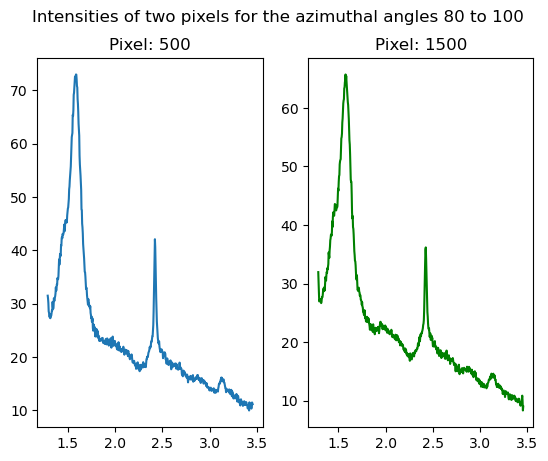

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Intensities of two pixels for the azimuthal angles {} to {}'.format(min_azimuthal_degree, max_azimuthal_degree))
ax1.plot(data['q'], data['I'][pixel_1])
ax1.set_title('Pixel: {}'.format(pixel_1))
ax2.plot(data['q'], data['I'][pixel_2], 'g')
ax2.set_title('Pixel: {}'.format(pixel_2))

Text(0.5, 1.0, 'Pixel: 1500')

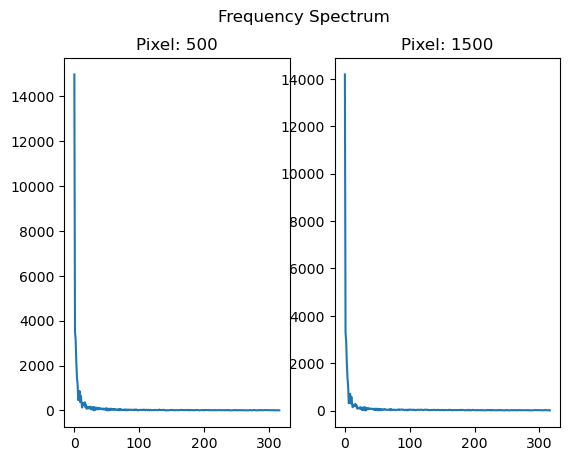

In [27]:
f_hat_dft_1 = np.fft.rfft(data['I'][pixel_1])
f_hat_dft_2 = np.fft.rfft(data['I'][pixel_2])

frequencies = np.fft.rfftfreq(data['q'].size, 1 / data['q'].size)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Frequency Spectrum')
ax1.plot(frequencies, np.abs(f_hat_dft_1))
ax1.set_title('Pixel: {}'.format(pixel_1))
ax2.plot(frequencies, np.abs(f_hat_dft_2))
ax2.set_title('Pixel: {}'.format(pixel_2))

    # 1. Analyze .h5 data  
We start our exploration by loading the desired file, in this case `scan-0035.h5`, and look what groups the data file contains. This is what is referred to as the master file in the measurement. I'm not really sure what that means.
 
The top level group is called `entry` which in turn contains some groups and datasets.  
The file contains a bunch of data that I don't understand what it is. One can explore it further by examining the group hierarchies (which work like dictionaries) and datasets (that work like Numpy arrays). We will focus on the data contained in `entry/title` and `entry/instrument/albaem-e01_ch1/data`. In order to work with the data in a reasonable manner we save `entry/title` to a dictionary `metadata` and keep the intensity data`entry/instrument/albaem-e01_ch1/data` as a Numpy array.

In [ ]:
file_path = os.getcwd().replace('chalmers', 'data/scan-0035.h5')
print("Reading file: {}".format(file_path))
with h5py.File(file_path, 'r') as fh:
    print("The .h5 data contains top level key: {}".format(list(fh.keys())))
    print("Under the 'entry' key we find the keys: {}".format(list(fh['entry'].keys())))
    print("Measurement content: {}".format(list(fh['entry']['measurement'].keys())))
    #data = fh['entry']['instrument']['albaem-e01_ch1']['data']

Now lets move on to the `scan-0035_lambda.h5` file that contains the data measured using the lambda detector. This detector is used to capture the WAXS data. In this part we simply use the code from `swaxs_analysis3.ipynb` to plot the raw WAXS data.

In [ ]:
image_to_plot = 1
file_path = os.getcwd().replace('chalmers', 'data/scan-0035_lambda.h5')
with h5py.File(file_path, 'r') as fh:
    full_shape = fh['/entry/instrument/lambda/full_shape'][()]
    rotation = fh['/entry/instrument/lambda/rotation'][()]
    x = fh['/entry/instrument/lambda/x'][()]
    y = fh['/entry/instrument/lambda/y'][()]
    data = fh['/entry/instrument/lambda/data'][image_to_plot, :, :, :]
fulldata = np.empty(full_shape)
fulldata[:] = np.nan
for i in range(4):
    rotdata = np.rot90(data[i, :, :], -rotation[i] / 90)  # rotate each detector
    fulldata[y[i]:y[i] + rotdata.shape[0], x[i]:x[i] + rotdata.shape[1]] = rotdata
plt.imshow(fulldata, norm="log")
fulldata = None
rotdata = None

Along with the raw data files, MaxIV is also supplying integrated data which is easier to work with. We go on loading one of those files. We load the lambda detector data which is the WAXS data. 

Here we just copy supplied code from MaxIV to load the data.

In [ ]:
"""
keys in file that will be loaded
    **FROM AZINT FILE**
    'I' : cake plot from radial integration, ordering (image,azimuthal,q) 
    'azi', : azimuthal bins
    'mask_file', : file path for mask used for radial integration
    'norm', : weights/norm sum for computing averages for integrated data, (azimuthal and q)
    'polarization_factor', : polarisation factor used for integration
    'poni_file', : file path for pony file
    'q', : q Vektor for integration
    **FROM MASTER FILE**
    'i_t', : diode data, transmittance for 2D map
    'dt' : exposure time from eiger/lambda/diode
    'title' :  scan command from SPOCK
    'swaxs_x' : swaxs_x stage position (encoder reading)
    'swaxs_y' : swaxs_y stage position (theoretical reading)
    'swaxs_rot' : swaxs_y stage position (theoretical reading)
    'time' : time point for triggers for exposure
"""

file_path = os.getcwd().replace('chalmers', 'data/scan-0035_lambda_integrated.h5')

data = {}
items = {
    'I': 'entry/data2d/cake',
    'q': 'entry/data1d/q',
    'azi': 'entry/data2d/azi',
    'mask_file': 'entry/azint/input/mask_file',
    'norm': 'entry/data2d/norm',
    'polarization_factor': 'entry/azint/input/polarization_factor',
    'poni': 'entry/azint/input/poni',
}
with h5py.File(file_path, 'r') as fh:
    for key, name in items.items():
        if name in fh:
            data[key] = fh[name][()]

master = file_path.replace('_lambda_integrated', '')
items = {
    'i_t': 'entry/instrument/albaem-e01_ch1/data',
    'title': 'entry/title'
}
with h5py.File(master, 'r') as fh:
    for key, name in items.items():
        if name in fh:
            data[key] = fh[name][()]

data['shape'] = (int((str(data['title']).split(' '))[8]) + 1, int((str(data['title']).split(' '))[4]))


Now lets examine the loaded data. 

We see that the array 'I' has shape (3050, 180, 2000). This means that this measurement contains 3050 images, 180 azimuthals and 2000 q values.
An image is one x-ray scan at a given point. Then the next scan is performed at a small displacement next to the previous.
The azimuthals are the angle of the measurements ranging from 1.0 to 359.0, $\xi \in [1, 359]$.
The q values are defined as in eq. (2.6) in (Björn, 2018) $\vert \overrightarrow{q} \vert = q = \frac{4 \pi}{\lambda} \sin \frac{\theta}{2}$. 

To further understand the data we can look at figures 2.13 and 3.6 in (Björn, 2018). 

In figure 2.13 we see how *ONE* image is produced. $\overrightarrow{q}$ is a vector that we norm using the above formula.
![Figure 2.13 (Björn, 2018)](images/fig2-13_bjorn_2018.png)

Now for every image, instead of having the normal cartesian coordinate system we can use the polar coordinate system where a point is given by a rotation and a distance. This can be seen in figure 3.6 where the azimuthal degree $\xi$ is the rotation and $q$ is the distance. For one image, a point $(q, \xi)$ corresponds to one hit of a photon on that point on the detector.
![Figure 3.6 (Björn, 2018)](images/fig3-6_bjorn_2018.png)

Lets pick take the same image as for the raw data and plot the similar image but using the integrated data. 

In [ ]:
""" Reshape the intensity function to have its first two coordinate being the row and the column
With I(img_number,azi,q) as input, the output is I(row,column,azi,q)
"""
data['I'] = data['I'].reshape((data['shape'][0], data['shape'][1], data['azi'].shape[0], data['q'].shape[0]))
#Since it is a snake scan, we need to flip every other row.
data['I'][1::2, :, :, :] = data['I'][1::2, ::-1, :, :]

# 2 Curve fit

Now we will try to do a Fourier transform to fit the data. We will eventually use all images of the data set but lets start by only loading one image to reduce memory use.

In [ ]:
image_to_analyze = 500

In [ ]:
file_path = os.getcwd().replace('chalmers', 'data/scan-0035_lambda_integrated.h5')

data = {}
items = {
    'I': 'entry/data2d/cake',
    'q': 'entry/data1d/q',
    'azi': 'entry/data2d/azi',
    'norm': 'entry/data2d/norm',
}
with h5py.File(file_path, 'r') as fh:
    for key, name in items.items():
        if name in fh:
            if key == 'I':
                data[key] = fh[name][image_to_analyze][()]
            else:
                data[key] = fh[name][()]

master = file_path.replace('_lambda_integrated', '')
items = {
    'title': 'entry/title'
}
with h5py.File(master, 'r') as fh:
    for key, name in items.items():
        if name in fh:
            data[key] = fh[name][()]

data['shape'] = (int((str(data['title']).split(' '))[8]) + 1, int((str(data['title']).split(' '))[4]))

We will use a more refined way to determine what azimuthal angles and q ranges to integrate over later. For now, we simply take azimuthal angles $\xi \in \{ 80, 100 \}$ and q intensities $q \in [ 0.00385, 3) $.

We construct two vectors that corresponds to these indices in the intensities matrix.

In [6]:
azimuthal_indices = np.asarray((data['azi'] < 100) | (data['azi'] > 80)).nonzero()[0]
q_range_indices = np.asarray(data['q'] < 3).nonzero()[0]

Now lets integrate over the angles corresponding to indices in `azimuthal_indices`. I dont really understand how to handle the integration properly so lets just make something for now. It is weird that this even works since we are dividing with 0 for many of the elements... To handle this we remove all the elements in the integrated vector that are divided by zero and undefined (nan).

In [ ]:
I = (np.sum(data['I'][azimuthal_indices, :] * data['norm'][azimuthal_indices, :], axis=0) / np.sum(
    data['norm'][azimuthal_indices, :], axis=0))[q_range_indices]
q = data['q'][q_range_indices]

defined_indices = ~np.isnan(I)
I = I[defined_indices]
q = q[defined_indices]

Now we have that intensity $I$ is only depending on $q$ and we can plot it. 

In [ ]:
plt.plot(q, I)
plt.xlabel("q (Å^-1)")
plt.ylabel("I (A.U)")

## Fourier transform
Now lets try to fit a Fourier transform to approximate the function $I(q)$.

We need to know whether the data is equi-distanced or not.

In [ ]:
dist_0 = q[1] - q[0]
max_baseline_difference = 0
for i in range(len(q) - 1):
    dist = q[i + 1] - q[i]
    if dist != dist_0:
        baseline_difference = np.abs(dist - dist_0)
        if baseline_difference > max_baseline_difference:
            max_baseline_difference = baseline_difference
        print(
            "Distance between points at indices {} and {} differ by {}. This difference diverges from baseline by {}.".format(
                i + 1, i, dist, baseline_difference))
print("Maximum baseline difference: {}".format(max_baseline_difference))

We see that the $q$ values are very close to equi-distanced but not completely. We start by fitting a non-uniform Fourier transform and try to shift the data and make a (equi-distanced) Fourier transform later.

In [ ]:
f_hat_dft = np.fft.rfft(I)
frequencies = np.fft.rfftfreq(I.size, 1 / I.size)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Frequency Spectrum')
ax1.plot(frequencies, np.abs(f_hat_dft))
ax2.plot(frequencies, np.log(np.abs(f_hat_dft)))

In [ ]:
N = f_hat_dft[np.log(np.abs(f_hat_dft)) > 4].size
f_dft = np.fft.rifft(f_hat_dft, n=N)

plt.plot(np.linspace(np.min(q), np.max(q), f_dft.size), np.abs(f_dft))
plt.xlabel("q (Å^-1)")
plt.ylabel("I (A.U)")